[*********************100%***********************]  1 of 1 completed


{'num_trades': 0.0, 'total_pnl': 0.0, 'avg_pnl_per_trade': 0.0}

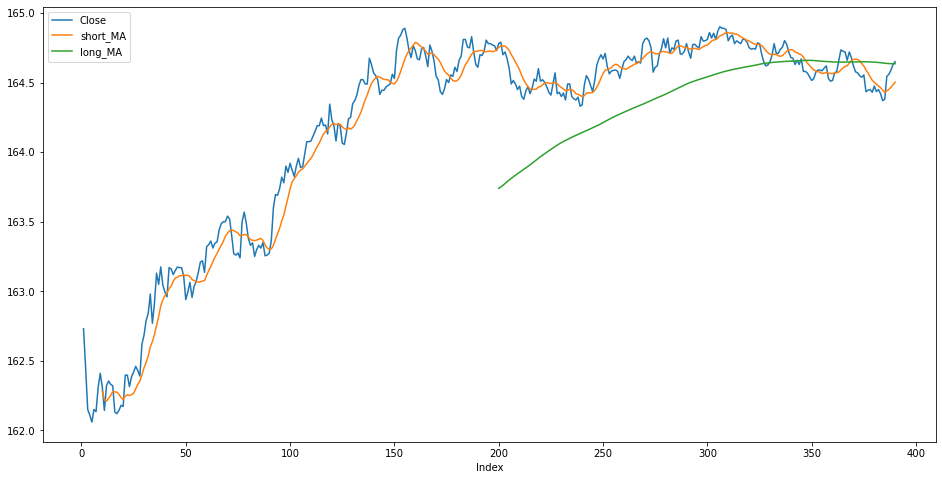

In [126]:
#period: The number of days/month of stock market data required. 
#The valid frequencies are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max

#interval: The frequency of the stock market data. 
#The valid intervals are 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

def calculate_PnL(ticker, period, interval, short_MA, long_MA):
    df = yf.download(tickers=ticker,
                            period=period,
                            interval=interval,
                            auto_adjust=True)
    df['Index'] = range(1, len(df)+1)
    df = df.set_index('Index')
    # Calculates the moving averages
    df['short_MA'] = df['Close'].rolling(window=short_MA).mean()
    df['long_MA'] = df['Close'].rolling(window=long_MA).mean()
    df['short_lag1_MA'] = df['short_MA'].shift(-1)
    df['long_lag1_MA'] = df['long_MA'].shift(-1)
    # Generates trading signals based on the moving averages
    df['sell'] = np.where((df['short_MA'] > df['long_MA']) & (df['short_MA'].shift(-1) < df['long_MA'].shift(-1)), -1.0, 0)
    df['buy'] = np.where((df['short_MA'] < df['long_MA']) & (df['short_MA'].shift(-1) > df['long_MA'].shift(-1)), 1.0, 0)
    # Calculates the PnL for each day
    df['buy_price'] = df['Close'].where(df['buy'] == 1.0)
    df['sell_price'] = df['Close'].where(df['sell'] == -1.0)
    df['PnL'] = (df['buy_price'] - df['sell_price'])
    # Calculates summary information
    num_trades = df['buy_price'].diff().abs().sum() + df['sell_price'].diff().abs().sum()
    total_pnl = df['PnL'].sum()
    avg_pnl_per_trade = total_pnl / num_trades if num_trades != 0 else 0.0
    summary = {'num_trades': num_trades,
               'total_pnl': total_pnl,
               'avg_pnl_per_trade': avg_pnl_per_trade}
    df[['Close', 'short_MA', 'long_MA']].plot(label = ticker, figsize = (16, 8))
    plt.legend()
    return summary

calculate_PnL("AAPL", "1d", "1m", 10, 200)

In [129]:
df = yf.download(tickers="AAPL",
                            period="1d",
                            interval="1m",
                            auto_adjust=True)
df['short_MA'] = df['Close'].rolling(window = 10).mean()
df['long_MA'] = df['Close'].rolling(window = 200).mean()
df['short_lag1_MA'] = df['short_MA'].shift(-1)
df['long_lag1_MA'] = df['long_MA'].shift(-1)
df['sell'] = np.where((df['short_MA'] > df['long_MA']) & (df['short_MA'].shift(-1) < df['long_MA'].shift(-1)), -1.0, 0)
df['buy'] = np.where((df['short_MA'] < df['long_MA']) & (df['short_MA'].shift(-1) > df['long_MA'].shift(-1)), 1.0, 0)
df['buy_price'] = df['Close'].where(df['buy'] == 1.0)
df['sell_price'] = df['Close'].where(df['sell'] == -1.0)
df['PnL'] = (df['buy_price'] - df['sell_price'])
    
df.to_csv("AAPL1.csv")

[*********************100%***********************]  1 of 1 completed


In [40]:
'''
In this example, a long position is represented by a trading signal of 1, and a short position is represented by a trading signal of -1.

When the short-term moving average (short_MA) is greater than the long-term moving average (long_MA), it generates a signal to go long, meaning to buy the stock. 
Conversely, when the short-term moving average is less than the long-term moving average, it generates a signal to go short, meaning to sell the stock short.

Thus, the 'signal' column in the DataFrame represents whether the strategy recommends a long position (signal=1), short position (signal=-1), or no position (signal=0) in the stock.

'''

"\nIn this example, a long position is represented by a trading signal of -1, and a short position is represented by a trading signal of 1.\n\nWhen the short-term moving average (short_MA) is greater than the long-term moving average (long_MA), it generates a signal to go long, meaning to buy the stock. \nConversely, when the short-term moving average is less than the long-term moving average, it generates a signal to go short, meaning to sell the stock short.\n\nThus, the 'signal' column in the DataFrame represents whether the strategy recommends a long position (signal=1), short position (signal=-1), or no position (signal=0) in the stock.\n\n"

In [101]:
import pandas as pd
import yfinance as yf
import numpy as np

def download_stock_data(ticker, period, interval):
    stock_data = yf.download(tickers=ticker,
                             period=period,
                             interval=interval,
                             auto_adjust=True)
    return stock_data

def calculate_PnL(stock_data, short_MA, long_MA):
    df = stock_data.copy()
    df['short_MA'] = df['Close'].rolling(window=short_MA).mean()
    df['long_MA'] = df['Close'].rolling(window=long_MA).mean()
    df['signal'] = 0.0
    df['signal'] = np.where((df['short_MA'] > df['long_MA']) & (df['short_MA'].shift(-1) < df['long_MA'].shift(-1)), 1.0, 0)
    df['signal'] = np.where((df['short_MA'] < df['long_MA']) & (df['short_MA'].shift(-1) > df['long_MA'].shift(-1)), -1.0, 0)
    df['shares'] = df['signal'].shift(1).fillna(0.0)
    df['trade_price'] = df['Open'].shift(-1)
    df['PnL'] = df['shares'] * (df['trade_price'] - df['Close'])
    return df['PnL'].sum()

def analyze_combinations(ticker, period, interval, short_MA_range, long_MA_range):
    results = pd.DataFrame(index=short_MA_range, columns=long_MA_range)
    stock_data = download_stock_data(ticker, period, interval)
    for short_MA in short_MA_range:
        for long_MA in long_MA_range:
            if short_MA < long_MA:
                pnl = calculate_PnL(stock_data, short_MA, long_MA)
                results.at[short_MA, long_MA] = pnl
            else:
                results.at[short_MA, long_MA] = np.nan
    return results.astype(float)

ticker = 'MSFT'
period = '1d'
interval = '1m'
short_MA_range = range(5, 101, 5)
long_MA_range = range(10, 201, 10)

pnl_matrix = analyze_combinations(ticker, period, interval, short_MA_range, long_MA_range)
print(pnl_matrix)

max_pnl = pnl_matrix.max().max()
max_pnl_column = pnl_matrix.max().idxmax()
max_pnl_row = pnl_matrix[max_pnl_column].idxmax()

print(f"The highest PnL of {max_pnl} is achieved with a short moving average of {max_pnl_row} days and a long moving average of {max_pnl_column} days.")

[*********************100%***********************]  1 of 1 completed
          10        20        30        40        50        60        70   \
5   -0.001312  0.091705  0.061981  0.015472  0.052399  0.017487 -0.024994   
10        NaN -0.011688 -0.009583  0.012482  0.004913 -0.004791  0.004517   
15        NaN -0.009888  0.027588  0.022614  0.021484  0.020020 -0.035004   
20        NaN       NaN  0.003418  0.028961  0.008606  0.040009  0.010010   
25        NaN       NaN -0.030029 -0.007629 -0.001709 -0.052673  0.000000   
30        NaN       NaN       NaN  0.040009  0.030029  0.045013  0.000000   
35        NaN       NaN       NaN  0.011780 -0.045898  0.035004 -0.019989   
40        NaN       NaN       NaN       NaN  0.015106  0.008392  0.000122   
45        NaN       NaN       NaN       NaN  0.040009 -0.029968 -0.040009   
50        NaN       NaN       NaN       NaN       NaN -0.009888 -0.039978   
55        NaN       NaN       NaN       NaN       NaN  0.039490  0.012512   
60     